<a href="https://colab.research.google.com/github/Demilock/Macroeconomic-feature-prediction-using-ARIMA/blob/master/stock_predictor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from datetime import datetime
from keras.layers import Activation,GRU,Layer,Dropout
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from google.colab import files
import io
from pandas.plotting import lag_plot
from sklearn.ensemble import RandomForestRegressor
plt.style.use('fivethirtyeight')

     |████████████████████████████████| 51kB 3.9MB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [0]:
#getting S&P500 index
dfstock = web.DataReader('SPY', data_source='yahoo', start='2012-01-01', end='2019-12-17')


In [0]:
#getting Interest Rate data for USA
uploaded1 = files.upload()
dfIR = pd.read_csv(io.StringIO(uploaded1['interest_rate_2004.csv'].decode('utf-8')))

Saving interest_rate_2004.csv to interest_rate_2004 (6).csv


In [0]:
#getting Exchange Rate data for USA
uploaded2 = files.upload()
dfER = pd.read_csv(io.StringIO(uploaded2['exchange_rate_2004.csv'].decode('utf-8')))

Saving exchange_rate_2004.csv to exchange_rate_2004 (7).csv


In [0]:
#getting Oil Price data for USA
uploaded3 = files.upload()
dfOP = pd.read_csv(io.StringIO(uploaded3['oil_price_2004.csv'].decode('utf-8')))

Saving oil_price_2004.csv to oil_price_2004 (5).csv


In [0]:
#initialise rmse array
rmse_matrix=[]
rmse_matrix=np.array(rmse_matrix)


In [0]:
def stock_predictor(df1,df2,df3,df4):
  rmse=[]
  rmse=np.array(rmse)
  #LSTM model.........................................................................................
  def LSTM_model(df,name):
    #Convert the dataframe to a numpy array
    dataset = df.values
    #Get the number of rows to train the model on
    training_data_len = math.ceil( len(dataset) * .8 )
    #Scale the data
    scaler = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler.fit_transform(dataset)
    #Create the training data set
    #Create the scaled training data set
    train_data = scaled_data[0:training_data_len , :]
    #Split the data into x_train and y_train data sets
    x_train = []
    y_train = []
    pdb=2
    for i in range(pdb, len(train_data)):
      x_train.append(train_data[i-pdb:i, 0])
      y_train.append(train_data[i, 0])
    #Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    #Reshape the data
    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
    model.add(LSTM(50, return_sequences= False))
    model.add(Dense(25))
    model.add(Dense(1))
    #Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])
    #Train the model
    model.fit(x_train, y_train, batch_size=1, epochs=3)
    #Create the testing data set
    test_data = scaled_data[training_data_len - pdb: , :]
    #Create the data sets x_test and y_test
    x_test = []
    y_test = dataset[training_data_len:, :]
    for i in range(pdb, len(test_data)):
      x_test.append(test_data[i-pdb:i, 0])
    #Convert the data to a numpy array
    x_test = np.array(x_test)
    #Reshape the data
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))
    #Get the models predicted price values 
    predictions = model.predict(x_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = np.asarray(y_test)
    t_test=y_test
    t_test=np.concatenate(t_test).astype('float32')
    #Get the root mean squared error (RMSE)
    error = np.sqrt(mean_squared_error(t_test, predictions))
    #prepare for visualisation
    train = df[:training_data_len]
    valid = df[training_data_len:]
    valid=valid.astype('float32')
    train=train.astype('float32')
    #print(valid.shape)
    #print(predictions.shape)
    minm=min(valid.shape,predictions.shape)
    predictions=predictions[:minm[0],:]
    valid=valid.iloc[:minm[0],:]
    valid['Predictions'] = predictions
    #Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('LSTM_'+name)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('RMSE='+str(error), fontsize=18)
    plt.plot(train['values'])
    plt.plot(valid[['values', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
    plt.show()
    return error
  

  #ARIMA model....................................................................................
  def ARIMA_model(df,name):
    #Get the number of rows to train the model on
    training_data_len = math.ceil( len(df) * .8 )
    #prepare the train and test data
    train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
    train_ar = train_data['values'].values
    test_ar = test_data['values'].values
    #prepare the model and getting predictions
    history = [int(x) for x in train_ar]
    history=np.array(history)
    predictions = list()
    for t in range(len(test_ar)):
        model = ARIMA(history, order=(5,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test_ar[t]
        history=np.append(history,int(obs))
    #get error value
    error = np.sqrt(mean_squared_error(test_ar, predictions))
    #visualisation
    train = df[:training_data_len]
    valid = df[training_data_len:]
    valid=valid.astype('float32')
    train=train.astype('float32')
    predictions=np.array(predictions)
    minm=min(valid.shape,predictions.shape)
    predictions=predictions[:minm[0],:]
    valid=valid.iloc[:minm[0],:]
    valid['Predictions'] = predictions
    #Visualize the data
    plt.figure(figsize=(16,8))
    plt.title('ARIMA_'+name)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('RMSE='+str(error), fontsize=18)
    plt.plot(train['values'])
    plt.plot(valid[['values', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
    plt.show()
    return error
  
  #Random Forest Regressor model................................................................
  def randomforest_model(df,flag,name):
    #Get the number of rows to train the model on
    training_data_len = math.ceil( len(df) * .8 )
    #Create a new dataframe with only the 'values column
    data = df.filter(['values'])
    #Convert the dataframe to a numpy array
    dataset = data.values
    #Scale the data
    scaler1 = MinMaxScaler(feature_range=(0,1))
    scaler2 = MinMaxScaler(feature_range=(0,1))
    scaler3 = MinMaxScaler(feature_range=(0,1))
    scaled_data = scaler1.fit_transform(dataset)
    #Create the scaled training data set
    train_data = scaled_data[0:training_data_len , :]
    #Split the data into x_train and y_train data sets
    array=df.index
    array1=[]
    array1=np.array(array1)
    for i in array:
      if flag==0:
        array1=np.append(array1,datetime.strptime(str(i), '%Y-%m-%d %H:%M:%S').timestamp())
      else:
        array1=np.append(array1,datetime.strptime(str(i), '%Y-%m').timestamp())

      
    x_train = array1[:training_data_len]
    y_train = train_data[:,0]
    x_train=x_train.reshape(-1,1)
    x_train=scaler2.fit_transform(x_train)
    #Convert the x_train and y_train to numpy arrays 
    x_train, y_train = np.array(x_train), np.array(y_train)
    #build the model
    model = RandomForestRegressor(n_estimators=1000, max_depth=500, bootstrap=False, min_samples_leaf=1)
    #fitting the model
    model.fit(x_train, y_train)
    #Create the data sets x_test and y_test
    x_test = array1[training_data_len:]
    x_test=x_test.reshape(-1,1)
    x_test = scaler3.fit_transform(x_test)
    x_test=np.array(x_test)
    y_test = dataset[training_data_len:, :]
    #getting the predictions 
    x_test=np.asarray(x_test)
    predictions = model.predict(x_test)
    predictions=predictions.reshape(-1,1)
    predictions = scaler1.inverse_transform(predictions)
    #Get the root mean squared error (RMSE)
    error = np.sqrt(mean_squared_error(y_test, predictions))
    #Visualize the data
    train = data[:training_data_len]
    valid = data[training_data_len:]
    valid=valid.astype('float32')
    train=train.astype('float32')
    minm=min(valid.shape,predictions.shape)
    predictions=predictions[:minm[0],:]
    valid=valid.iloc[:minm[0],:]
    valid['Predictions'] = predictions
    plt.figure(figsize=(16,8))
    plt.title('Random Forest_'+name)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('RMSE='+str(error), fontsize=18)
    plt.plot(train['values'])
    plt.plot(valid[['values', 'Predictions']])
    plt.legend(['Train', 'Val', 'Predictions'], loc='upper left')
    plt.show()
    return error
  

  #preparing dataset format: close= closing value, IR=Interest Rate, ER=Exchange Rate, OP=Oil Price
  df1=df1.rename(columns={"Close": "values"})
  df_close=df1.filter(['values'])
  
  df2=df2.rename(columns={"Index": "Date", "Category: All categories": "values"})
  df2=df2.iloc[1:197,:]
  df_IR=df2.filter(['values'])
  
  df3=df3.rename(columns={"Index": "Date", "Category: All categories": "values"})
  df3=df3.iloc[1:197,:]
  df_ER=df3.filter(['values'])
  
  df4=df4.rename(columns={"Index": "Date", "Category: All categories": "values"})
  df4=df4.iloc[1:197,:]
  df_OP=df4.filter(['values'])
  #getting the rmse array ready and running the models
  rmse=np.append(rmse,LSTM_model(df_close,'close'))
  rmse=np.append(rmse,LSTM_model(df_IR,'IR'))
  rmse=np.append(rmse,LSTM_model(df_ER,'ER'))
  rmse=np.append(rmse,LSTM_model(df_OP,'OP'))
  rmse=np.append(rmse,ARIMA_model(df1,'close'))
  rmse=np.append(rmse,ARIMA_model(df2,'IR'))
  rmse=np.append(rmse,ARIMA_model(df3,'ER'))
  rmse=np.append(rmse,ARIMA_model(df4,'OP'))
  rmse=np.append(rmse,randomforest_model(df1,0,'close'))
  rmse=np.append(rmse,randomforest_model(df2,1,'IR'))
  rmse=np.append(rmse,randomforest_model(df3,1,'ER'))
  rmse=np.append(rmse,randomforest_model(df4,1,'OP'))
  #return the rmse matrix
  return rmse
  
  

  



    

Epoch 1/1
1601/1601 [==============================] - 9s 5ms/step - loss: 0.0018 - accuracy: 0.0000e+00


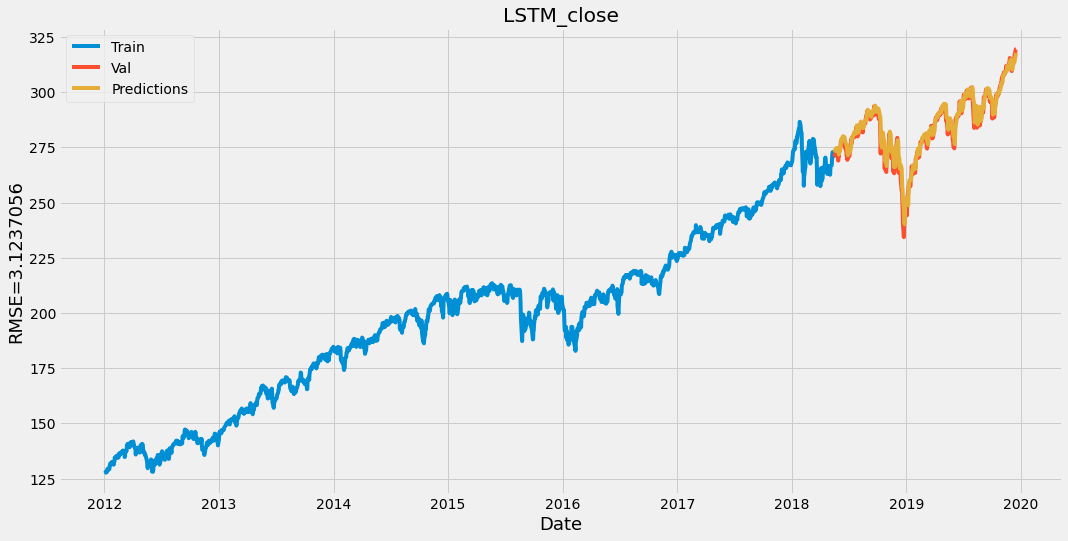

Epoch 1/1
155/155 [==============================] - 2s 11ms/step - loss: 0.0101 - accuracy: 0.0065


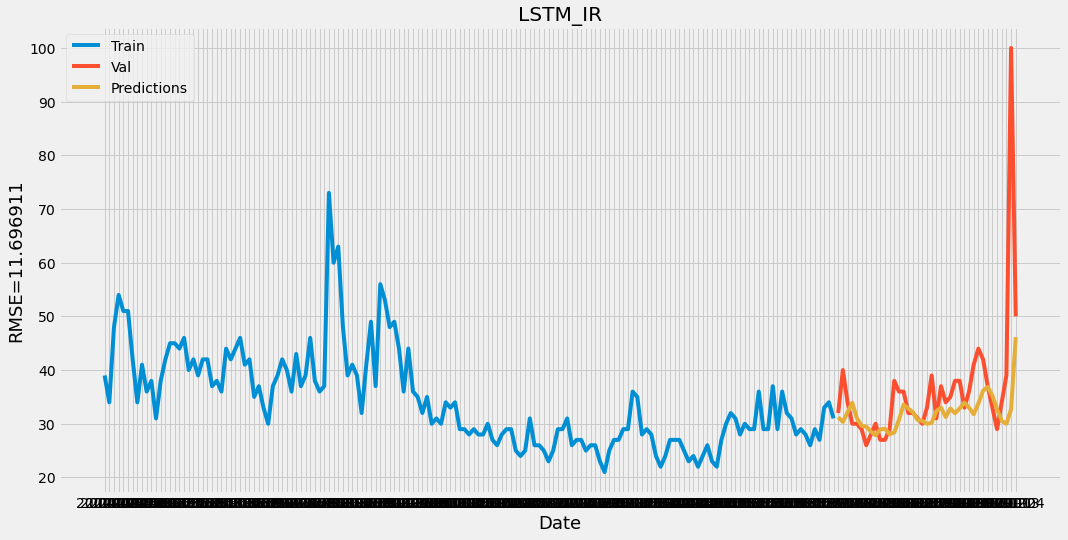

Epoch 1/1
155/155 [==============================] - 2s 10ms/step - loss: 0.0281 - accuracy: 0.0065


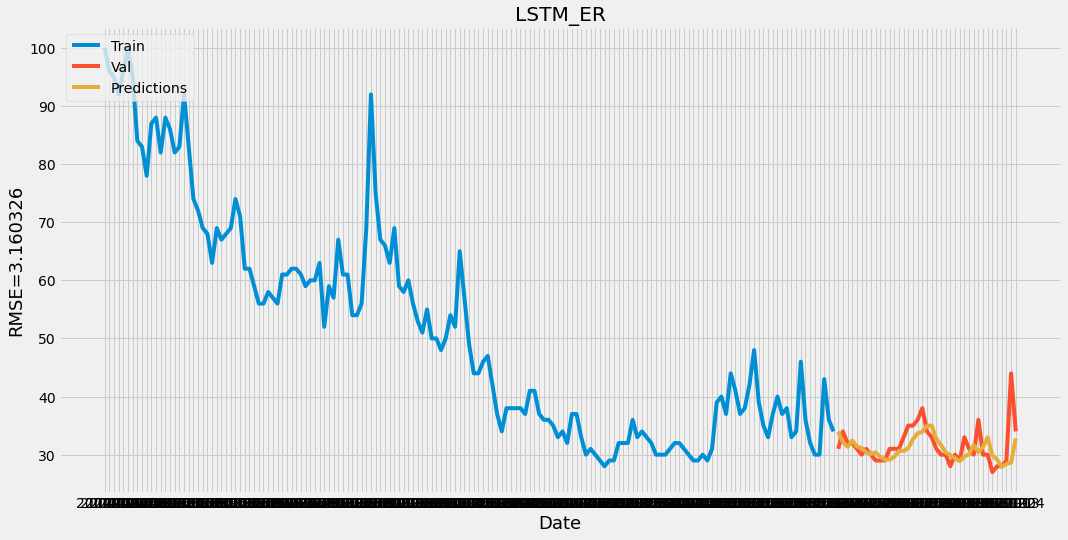

Epoch 1/1
155/155 [==============================] - 2s 10ms/step - loss: 0.0200 - accuracy: 0.0129


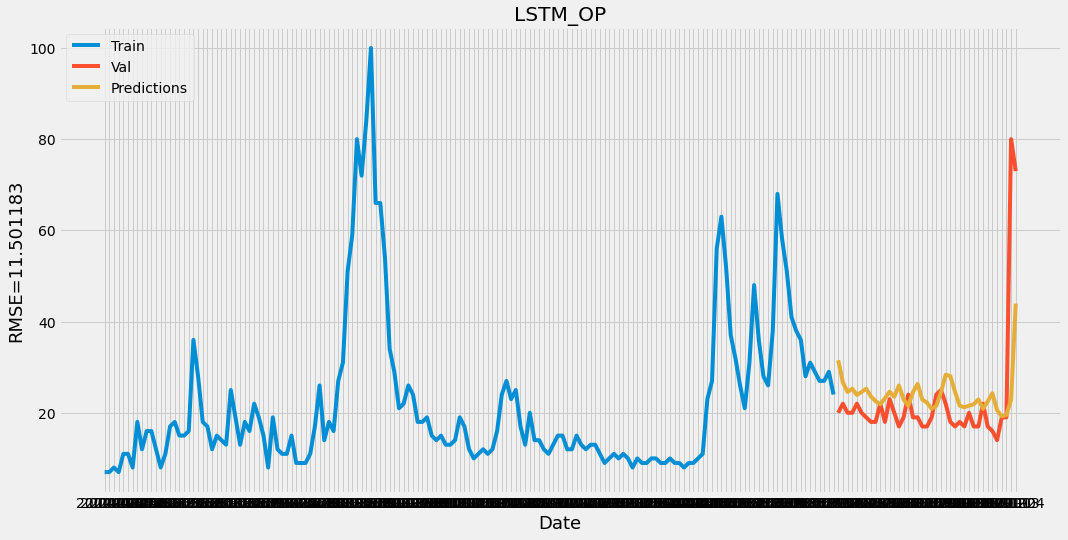

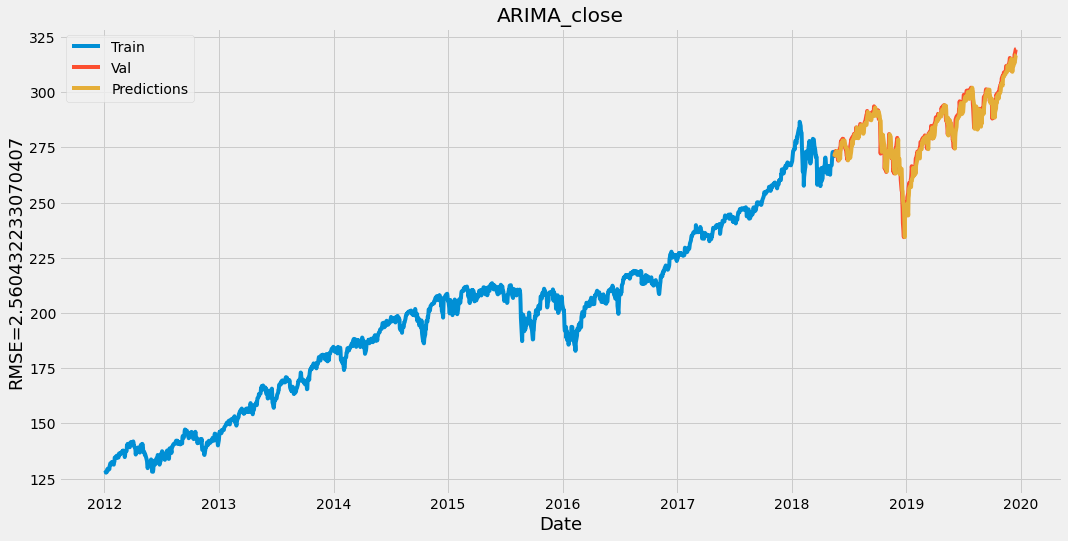

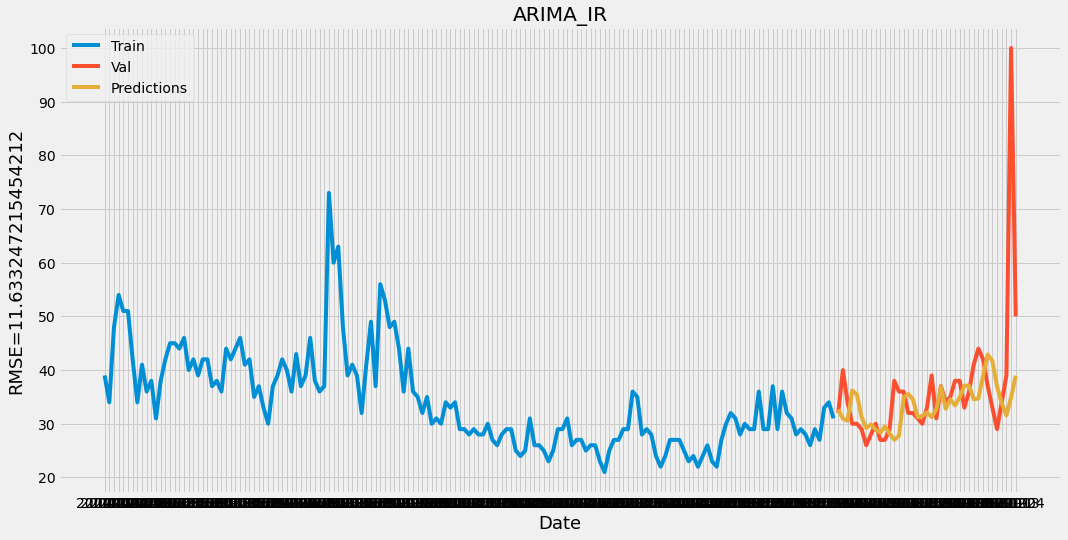

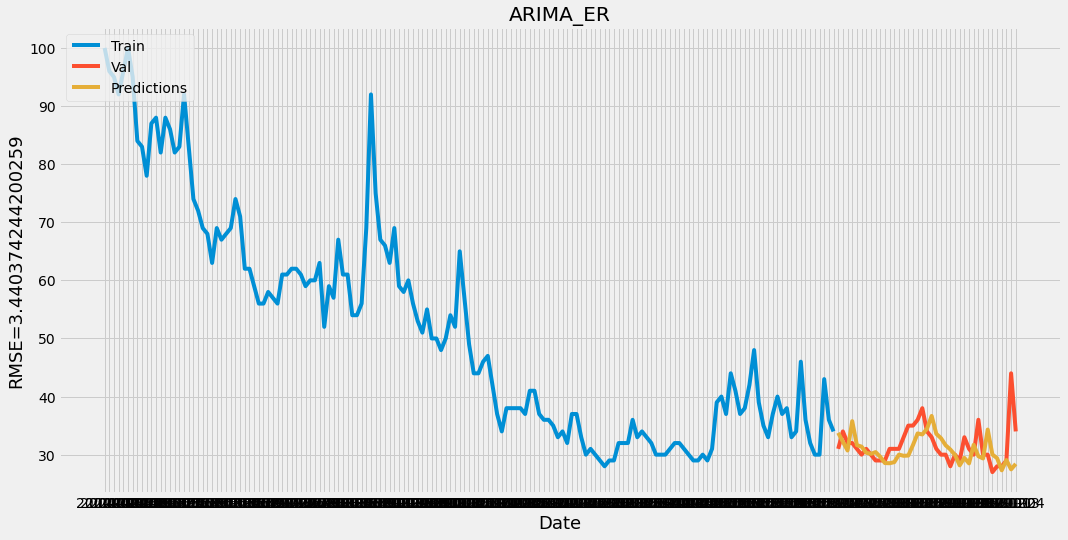

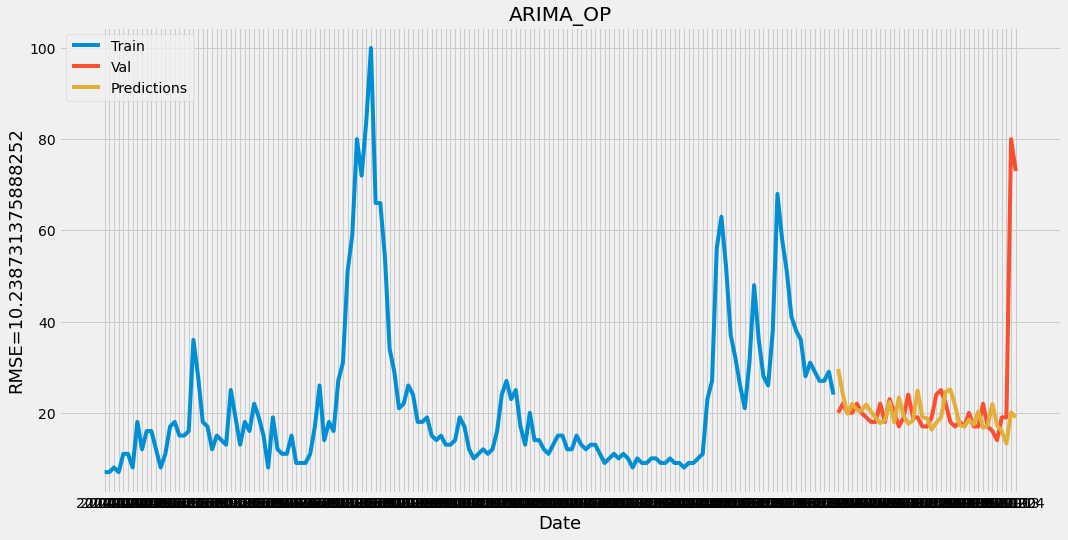

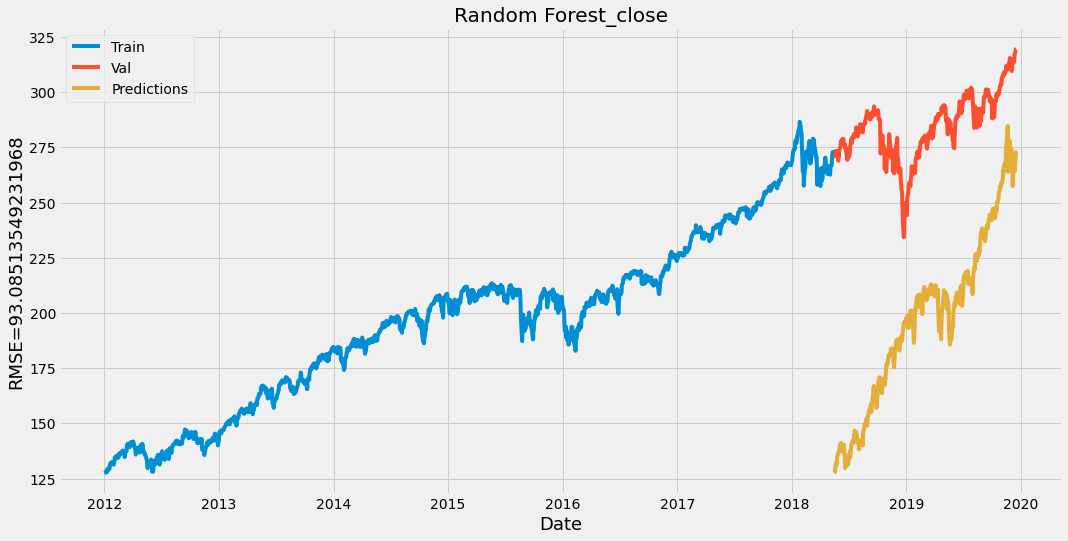

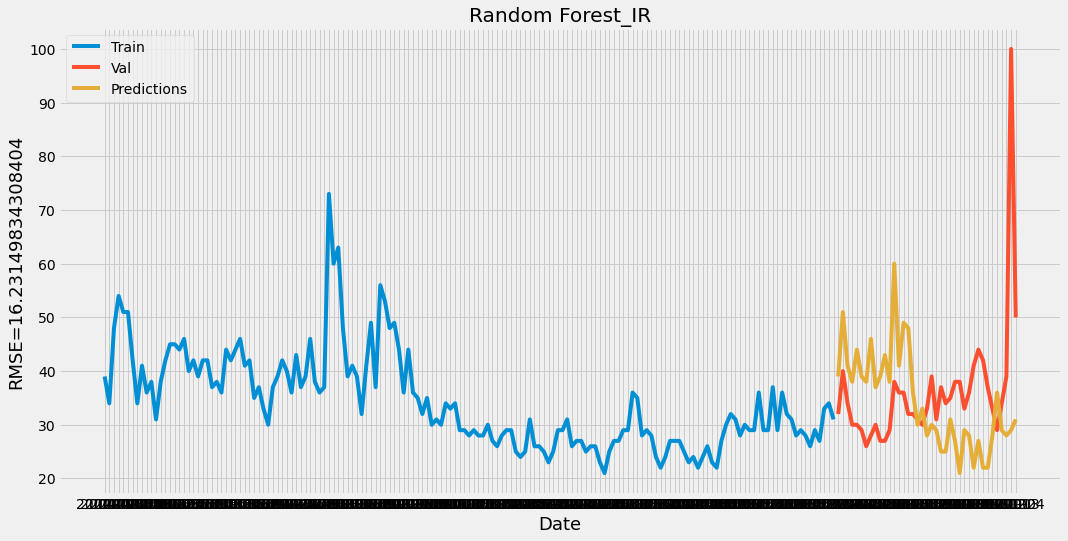

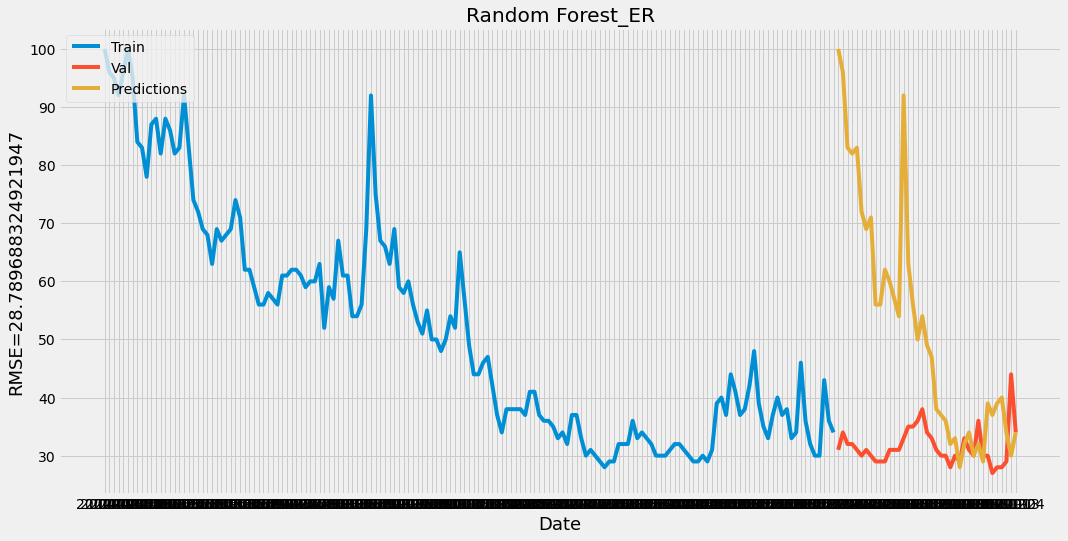

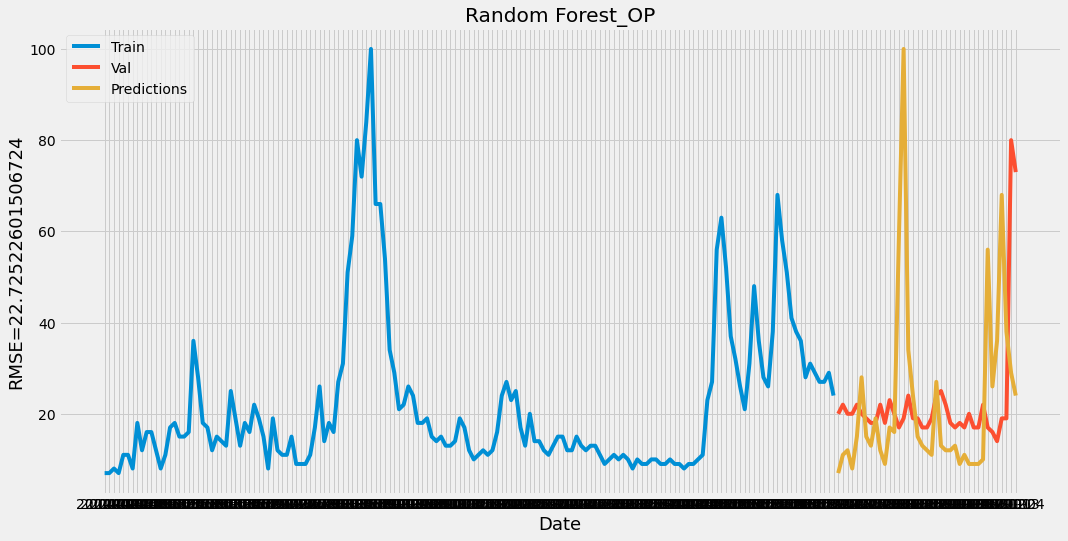

In [0]:
rmse_matrix=stock_predictor(dfstock,dfIR,dfER,dfOP)

In [0]:
print(rmse_matrix)

[ 3.12370563 11.69691086  3.160326   11.50118256  2.56043223 11.63324722
  3.44037424 10.23873138 93.08513549 16.23149834 28.78968832 22.72522602]


In [0]:
#reshaping the rmse matrix
rmse_matrix=np.reshape(rmse_matrix,(3,4))
print(rmse_matrix)

[[ 3.12370563 11.69691086  3.160326   11.50118256]
 [ 2.56043223 11.63324722  3.44037424 10.23873138]
 [93.08513549 16.23149834 28.78968832 22.72522602]]


In [0]:
#prepare proper format
row_names    = ['LSTM', 'ARIMA', 'RF']
pd_df = pd.DataFrame(rmse_matrix, columns=["close", "IR","ER","OP"], index=row_names)
print(pd_df)

           close         IR         ER         OP
LSTM    3.123706  11.696911   3.160326  11.501183
ARIMA   2.560432  11.633247   3.440374  10.238731
RF     93.085135  16.231498  28.789688  22.725226


In [0]:
#save the results
pd_df.to_csv('results.csv')
files.download('results.csv')